In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Embedding, Dropout, LSTM, Dense
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer


# fix random seed for reproducibility
#tf.random.set_seed(7)

df = pd.read_csv('../../data/normalized_tweets.csv')

df = df[df['cyberbullying_type'] != 'other_cyberbullying']
# Reset index after filtering out the class
df.reset_index(drop=True, inplace=True)

Embeddings: convert text in small dense vectores. Every token has n-dimentional aprameters explaining its characteristics. 

Pretrained GloVe embedding. 

In [2]:
X, y = df["tweet_text"], df["cyberbullying_type"]

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform label encoder on the target variable
y = label_encoder.fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [3]:
#Each word in input used as a key, while a unique index is used as the value of the key 
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(x_train)

X_train = word_tokenizer.texts_to_sequences(x_train)
X_test = word_tokenizer.texts_to_sequences(x_test)

vocab_length = len(word_tokenizer.word_index) + 1

print(vocab_length)

#df['text_len'] = [len(text.split()) for text in df.tweet_text]
max_len = 25 ### test different length because tweets are filled with lot of zeros

X_train = pad_sequences(X_train, padding = 'pre', maxlen = max_len)
X_test = pad_sequences(X_test, padding = 'pre', maxlen = max_len)

36047


In [36]:
X_train[10]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,  187,  159,
         20, 4047, 7835, 9275,   51,    8,    2, 5037,   40,   24,  138,
          2,    4,    8], dtype=int32)

Use GloVe embedding to create our feature matrix.

In [4]:
# Load GloVe word embeddings and create a dictionary that willl contain words as keys, and their corresponging embedding list as values. 

from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('../../glove_embeddings/glove.twitter.27B.200d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [5]:
embedding_matrix = zeros((vocab_length, 200))
i = 0
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
    else:
        i = i + 1
        print(word)
print(i)

2
3
1
4
5
100
10
6
12
7
13
8
20
911
15
2020
9
1400
30
middlehigh
1st
50
gamergate
14
17
40
18
2nd
200
4th
16
11
microbrain
90
33
covid
3rd
kobane
8th
23
25
drasko
covid19
128514
24
80
7th
daterape
99
2017
peshmerga
2019
2014
6th
2016
70
110
80s
22
45
60
300
questionsformen
400
wadhwa
nonmuslims
killerblondes
antimuslim
5th
19
ghazwahind
niggerlt
hindushindutvahindusthanhumanity
2018
cryand
0
2013
72
500
21
blacklivesmatter
2015
yesallwomen
darulharb
antichristian
cuntandandre
notsexist
rapegay
mkr2015
katandandre
28
600
farright
100s
56
2611
2gether
africanamerican
95
90s
2010
khybar
800
21st
247
9th
hindumuslim
34
madarsa
apostates
blameonenotall
26
onlyfans
77
isalm
h8
5sos
ggautoblocker
womenagainstfeminism
ezidi
redical
judeochristian
1990
4m
2002
2011
2012
150
altaqiya
gayrape
55
2001
lashkartaiba
10th
35
islamolunatics
tikrit
32
pornrama
98
mughals
spatchcock
hoors
muslimsjihadisterrorists
uyghurs
ypgypj
jehadi
1500
antifeminist
13yrold
decapolis
yazidi
75
any1
hinduphobiainarab


In [70]:
import fasttext

# Load FastText model
ft_model = fasttext.load_model('fasttext.model')

# Assuming `vocab_length` is the total number of unique words in your tokenizer
# and `embedding_dim` is the dimensionality of the FastText vectors (typically 100 or 300)
embedding_dim = 100
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding = ft_model.get_word_vector(word)
    if embedding is not None:
        embedding_matrix[index] = ft_model.get_word_vector(word)
    else:
        print(word)

In [6]:
num_classes = 5  # Change this to your number of classes

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 200, weights=[embedding_matrix], input_length=max_len, trainable=False)

lstm_model.add(embedding_layer)
#grid
lstm_model.add(Dropout(0.5))  
lstm_model.add(LSTM(256))
#grid
lstm_model.add(Dense(num_classes, activation='softmax'))

# Model compiling
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc']) 

lstm_model.build(input_shape=(None, max_len))

print(lstm_model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 200)           7209400   
                                                                 
 dropout (Dropout)           (None, 25, 200)           0         
                                                                 
 lstm (LSTM)                 (None, 256)               467968    
                                                                 
 dense (Dense)               (None, 5)                 1285      
                                                                 
Total params: 7678653 (29.29 MB)
Trainable params: 469253 (1.79 MB)
Non-trainable params: 7209400 (27.50 MB)
_________________________________________________________________
None


In [7]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
192/192 [==============================] - 13s 62ms/step - loss: 0.4528 - acc: 0.8405 - val_loss: 0.2795 - val_acc: 0.9005
Epoch 2/20
192/192 [==============================] - 13s 68ms/step - loss: 0.2857 - acc: 0.8969 - val_loss: 0.2451 - val_acc: 0.9124
Epoch 3/20
192/192 [==============================] - 13s 68ms/step - loss: 0.2466 - acc: 0.9122 - val_loss: 0.2318 - val_acc: 0.9145
Epoch 4/20
192/192 [==============================] - 12s 64ms/step - loss: 0.2238 - acc: 0.9186 - val_loss: 0.2145 - val_acc: 0.9214
Epoch 5/20
192/192 [==============================] - 13s 65ms/step - loss: 0.2046 - acc: 0.9242 - val_loss: 0.2226 - val_acc: 0.9201
Epoch 6/20
192/192 [==============================] - 12s 64ms/step - loss: 0.1902 - acc: 0.9313 - val_loss: 0.2077 - val_acc: 0.9271
Epoch 7/20
192/192 [==============================] - 14s 74ms/step - loss: 0.1797 - acc: 0.9352 - val_loss: 0.2038 - val_acc: 0.9280
Epoch 8/20
192/192 [==============================] - 15s 78ms

In [39]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)

240/240 [==============================] - 3s 13ms/step - loss: 0.1799 - acc: 0.9353


In [40]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.17988406121730804
Test Accuracy: 0.935278058052063


In [41]:
# Model Performance Charts
from sklearn.metrics import classification_report, confusion_matrix

# Predictions
y_pred = lstm_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion Matrix
print(confusion_matrix(y_test, y_pred_classes))

# Classification Report
print(classification_report(y_test, y_pred_classes))


240/240 [==============================] - 4s 15ms/step
[[1560    4    2   31    1]
 [   0 1566   12   31    5]
 [   2    6 1399  149    3]
 [  14    4  118 1127   46]
 [   0    5   11   53 1530]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1598
           1       0.99      0.97      0.98      1614
           2       0.91      0.90      0.90      1559
           3       0.81      0.86      0.83      1309
           4       0.97      0.96      0.96      1599

    accuracy                           0.94      7679
   macro avg       0.93      0.93      0.93      7679
weighted avg       0.94      0.94      0.94      7679



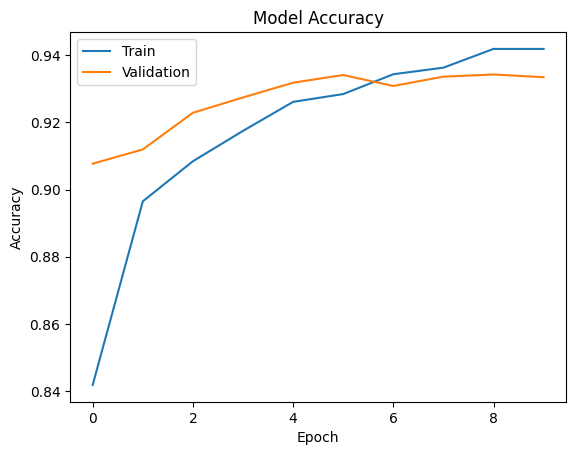

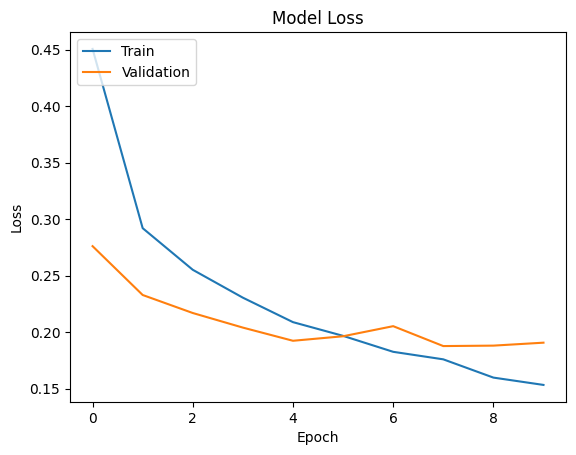

In [42]:
import matplotlib.pyplot as plt

# Plotting
plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Binary Classification